In [47]:
## Importing all the libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import os
from math import *
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [48]:
## Read the input data files 
path = "C:/Users/XABARBAD/Desktop/Work/KPI Validation & Importance/Model 2/KPI_New_Files/Datasets/"
df = pd.read_excel(path+"Inter_Files.xlsx",sheet_name = "UK_Files_New")

In [49]:
## Look at the input file
df.head()

Title  \
0                  A Way Out   
1                     Anthem   
2  Assassin's Creed: Odyssey   
3  Assassin's Creed: Origins   
4              Battlefield V   

   Nielsen - Metrics Purchase interest - Def not_mean  \
0                                           0.280091    
1                                           0.265638    
2                                           0.199460    
3                                           0.212809    
4                                           0.213515    

   Nielsen - Metrics Purchase interest - Def_mean  \
0                                        0.115765   
1                                        0.102854   
2                                        0.174302   
3                                        0.157252   
4                                        0.152882   

   Nielsen - Metrics First Choice_mean  \
0                             0.004900   
1                             0.014918   
2                             0.006987   
3                             0.015365   
4                             0.011096   

   Nielsen - Metrics Purchase interest - Own/Preorder_mean  \
0                                           0.014379         
1                                           0.016398         
2                                           0.029692         
3                                           0.027508         
4                                           0.024678         

   Nielsen - Metrics Purchase interest - Prob_mean  \
0                                         0.211567   
1                                         0.254323   
2                                         0.369184   
3                                         0.343178   
4                                         0.337963   

   Nielsen - Metrics Unaided Awareness_mean  Google_UK_mean  \
0                                  0.034883        0.381071   
1                                  0.056892        0.547057   
2                                  0.030756        0.977233   
3                                  0.046054        1.201071   
4                                  0.052968        1.390990   

   Marketing Metrics Net Sentiment_mean  \
0                              0.693605   
1                              0.335654   
2                              0.533764   
3                              0.724129   
4                              0.257173   

   Marketing Metrics PR Metrics and Articles_mean  ...  Franchise or Not  \
0                                     6549.142857  ...                 0   
1                                    84610.571429  ...                 0   
2                                    48118.428571  ...                 1   
3                                    47215.571429  ...                 1   
4                                    87549.571429  ...                 1   

   Prem SKU 3 months  Genre_Action_Adventure  Genre_Shooter  Genre_Sports  \
0                  0                       1              0             0   
1                  1                       0              0             0   
2                  1                       0              0             0   
3                  0                       1              0             0   
4                  1                       0              1             0   

   Genre_RP  Genre_Others  Top_Games_3M  Seasonality_Flag  UK_Rev_Group  
0         0             0             6                 0             3  
1         1             0             5                 0             1  
2         1             0             9                 1             2  
3         0             0             5                 1             2  
4         0             0             4                 1             1  

[5 rows x 59 columns]

In [50]:
#Remove titles with no Revenue
df = df[df['UK_Revenue'].notna()]
df.shape

(60, 59)

In [51]:
#### Functions to transform columns

def logTransform(x):
    if(x<=0):
        return 0
    else:
        return log(x)
    
def squareTransform(x):
    return pow(x,2)

def cubeTransform(x):
    return pow(x,3)

def squareRootTransform(x):
    if(x<=0):
        return 0
    else:
        return sqrt(x)

def cubeRootTransform(x):
    if(x<=0):
        return 0
    else:
        return x**(1./3)

In [52]:
#In case there are any missing values, replace them with the mean

def imputeData(df,titleColName):
    df1 = df.drop([titleColName],axis=1)
    imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
    imputer.fit(df1.values)
    df2 = pd.DataFrame(imputer.transform(df1))
    df2.columns = df1.columns
    df2.index = df1.index
    df3 = pd.concat([df[[titleColName]],df2],axis=1)
    return df3

df = imputeData(df, 'Title')

In [53]:
#Apply transformation to every column in the dataset

def getTransformedDF(df,titleColName):
    df2 = df.drop([titleColName],axis=1)
    cols = df2.columns
    df1 = df2[cols]
    for col in cols:
        df1['log('+col+')'] = df1[col].apply(lambda x:logTransform(x))
        df1['square('+col+')'] = df1[col].apply(lambda x:squareTransform(x))
        df1['cube('+col+')'] = df1[col].apply(lambda x:cubeTransform(x))
        df1['squareRoot('+col+')'] = df1[col].apply(lambda x:squareRootTransform(x))
        df1['cubeRoot('+col+')'] = df1[col].apply(lambda x:cubeRootTransform(x))
    df3 = pd.concat([df[[titleColName]],df1],axis=1)
    return df3

titleColName = 'Title'
df_transformed = getTransformedDF(df,titleColName)
df_transformed.shape

(60, 349)

In [54]:
### Get Col Names in Sequence so as to clearly visualise correlation
### Can be skipped

def getColsListSortedOrder(colsList,cols):
    colsNewList = []
    for stg in colsList:
        for col in cols:
            if(col.find(stg)!=-1):
                colsNewList.append(col)

    for col in cols:
        if col not in colsNewList:
            colsNewList.append(col)
        
    unique_col_list  = []    
    for col in colsNewList:
        if(col not in unique_col_list):
            unique_col_list.append(col)
    
    return unique_col_list

In [55]:
#Get the shape of the dataset
df.shape

(60, 59)

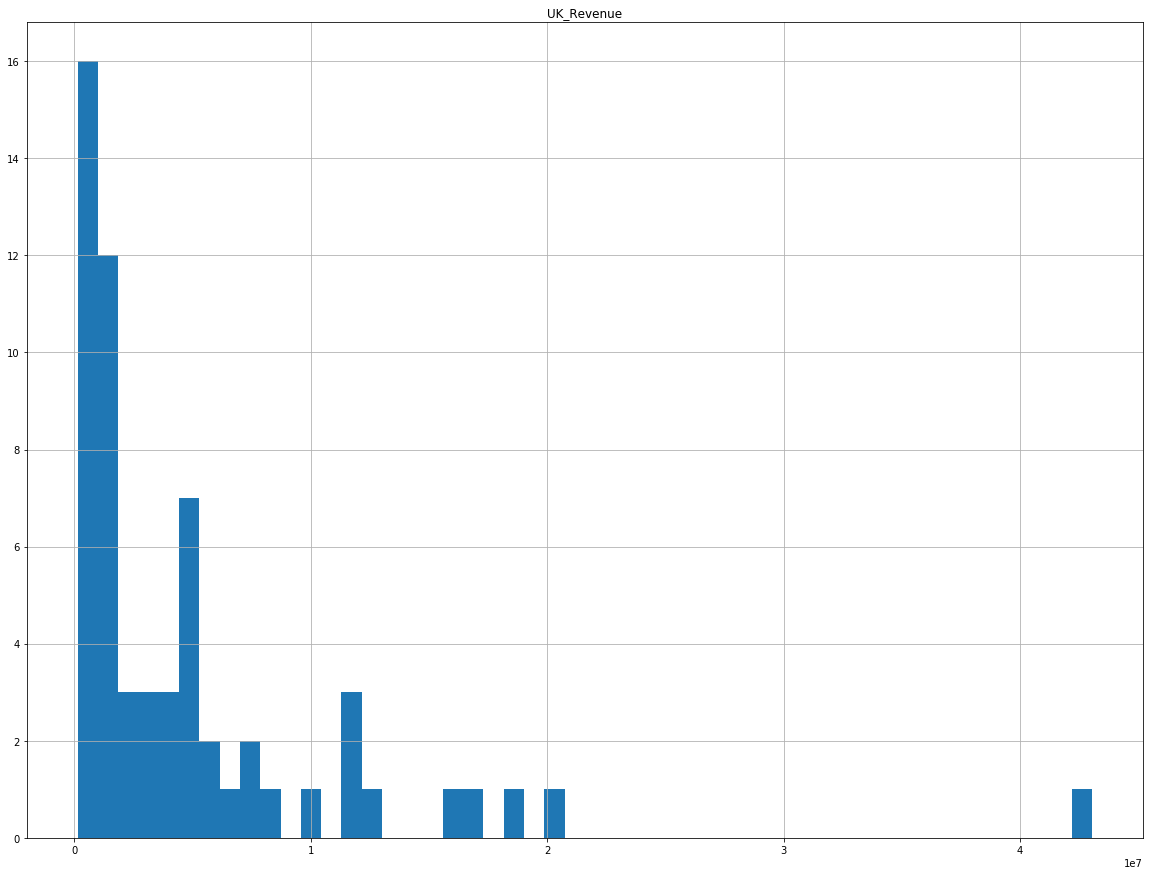

In [56]:
#Checking the distribution in UK Revenue to identify outliers
%matplotlib inline
import matplotlib.pyplot as plt
df_transformed.hist(column = 'UK_Revenue',bins = 50, figsize = (20,15))
plt.show()

In [57]:
#Remove outliers based on business knowledge & the above plot
titles = ['Call of Duty: Modern Warfare 2019']

df_transformed = df_transformed[~df_transformed.Title.isin(titles)]
df_transformed.shape

(59, 349)

In [58]:
#Removing more outliers by removing titles with revenue less than 16M
#16M was identified as the threshold because they had high error & we earlier saw a drop in error by deleting these

#Greater_than2m = df_transformed.UK_Revenue > 16000000
#print(df_transformed[Greater_than2m].shape)
#df_transformed = df_transformed[Greater_than2m]

In [59]:
#### Linear Regression
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

def getSplitTrainTest(df_X,df_Y,testSize,seed):
    X_train,X_test,Y_train,Y_test = train_test_split(df_X,df_Y,test_size=testSize,random_state=seed)
    return (X_train,X_test,Y_train,Y_test)

def getLinearModel(X_train,Y_train):
    lr_model_ols = sm.OLS(Y_train.values,X_train.values).fit()
    return (lr_model_ols,X_train.columns)

### Calculate Various Metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def Rsquare(yoriginal,ypred):
    SS_Residual = sum((yoriginal-ypred)**2)
    SS_Total = sum((yoriginal-np.mean(yoriginal))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    return r_squared
def adjRsquare(yoriginal,ypred,rank):
    SS_Residual = sum((yoriginal-ypred)**2)
    SS_Total = sum((yoriginal-np.mean(yoriginal))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    dfResid = len(yoriginal) - rank
    adjusted_r_squared = 1 - (1-r_squared)*(len(yoriginal)-1)/dfResid
    return adjusted_r_squared
def w_mape(y_true,y_pred):
    abs_error_percent = np.abs((y_true- y_pred)/y_true)*100
    return (sum(y_true*abs_error_percent)/sum(y_true))

### For VIF Analysis
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, 
                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
         for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs

In [60]:
#Dropping title since it's a categorical variable & Revenue because we're checking for Variance inflation & don't
#need the dependent variable

df_revenue_model = df_transformed.drop(['UK_Revenue', 'Title','log(UK_Revenue)','cube(UK_Revenue)',
                                       'squareRoot(UK_Revenue)','cubeRoot(UK_Revenue)','square(UK_Revenue)'], axis = 1)
df_revenue_vif  = df_revenue_model.loc[:].astype(float)
df_revenue_vif.shape

(59, 342)

In [61]:
#Checking the Variance inflation factor of the independent variables
revenue_vif = variance_inflation_factors(df_revenue_vif)
revenue_vif
revenue_vif.shape

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


(343,)

In [62]:
#Another method defined to calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [63]:
#Drop columns with VIF higher than the threshold defined earlier - 5.0

df_vif = calculate_vif_(df_revenue_vif)
df_vif.shape
df_vif.columns

dropping 'cube(Marketing Metrics PR Metrics and Articles_max)' at index: 214
dropping 'cube(Netbase - Metrics Mentions_mean)' at index: 149
dropping 'cube(Netbase - Metrics Impressions_mean)' at index: 144
dropping 'cube(Netbase - Metrics Posts_mean)' at index: 152
dropping 'cube(Tubular - Metrics Views_mean)' at index: 139
dropping 'cube(Marketing Metrics PR Metrics and Articles_mean)' at index: 99
dropping 'square(Netbase - Metrics Impressions_mean)' at index: 141
dropping 'cube(Tubular - Metrics Views_max)' at index: 247
dropping 'cube(Netbase - Metrics Totalreposts_max)' at index: 271
dropping 'cube(Marketing Metrics Unaided Awareness_mean)' at index: 118
dropping 'cube(Tubular - Metrics Engagements_max)' at index: 236
dropping 'square(Tubular - Metrics Views_mean)' at index: 136
dropping 'square(Tubular - Metrics Engagements_mean)' at index: 126
dropping 'cube(Tubular - Metrics Uploads_mean)' at index: 131
dropping 'square(Tubular - Metrics Views_max)' at index: 241
dropping 'cube

dropping 'cubeRoot(Marketing Metrics Twitter Activity_max)' at index: 132
dropping 'cubeRoot(Net Sentiment_max)' at index: 158
dropping 'cubeRoot(Marketing Metrics Purchase Intent_max)' at index: 130
dropping 'squareRoot(Marketing Metrics Views_max)' at index: 132
dropping 'squareRoot(Netbase - Metrics Impressions_max)' at index: 146
dropping 'cubeRoot(Tubular - Metrics Views_max)' at index: 144
dropping 'squareRoot(Net Sentiment_max)' at index: 153
dropping 'cubeRoot(Marketing Metrics Twitter Activity_mean)' at index: 69
dropping 'squareRoot(Tubular - Metrics Views_mean)' at index: 77
dropping 'cubeRoot(Netbase - Metrics Totalreplies_mean)' at index: 83
dropping 'cubeRoot(Marketing Metrics PR Metrics and Articles_mean)' at index: 65
dropping 'squareRoot(Tubular - Metrics Uploads_mean)' at index: 73
dropping 'cubeRoot(Net Sentiment_mean)' at index: 84
dropping 'squareRoot(Marketing Metrics Unaided Awareness_max)' at index: 127
dropping 'squareRoot(Netbase - Metrics Posts_max)' at index

Index(['Nielsen - Metrics Purchase interest - Def not_mean',
       'Nielsen - Metrics Purchase interest - Def_mean',
       'Nielsen - Metrics Purchase interest - Own/Preorder_mean',
       'Nielsen - Metrics Purchase interest - Prob_mean',
       'Nielsen - Metrics Unaided Awareness_mean',
       'Marketing Metrics Net Sentiment_mean',
       'Netbase - Metrics Impressions_mean',
       'Nielsen - Metrics Purchase interest - Def not_max',
       'Nielsen - Metrics Purchase interest - Def_max',
       'Nielsen - Metrics First Choice_max',
       ...
       'log(Seasonality_Flag)', 'square(Seasonality_Flag)',
       'cube(Seasonality_Flag)', 'squareRoot(Seasonality_Flag)',
       'cubeRoot(Seasonality_Flag)', 'log(UK_Rev_Group)',
       'square(UK_Rev_Group)', 'cube(UK_Rev_Group)',
       'squareRoot(UK_Rev_Group)', 'cubeRoot(UK_Rev_Group)'],
      dtype='object', length=186)

In [64]:
#Checking the sample output

df_vif.head()

Nielsen - Metrics Purchase interest - Def not_mean  \
0                                           0.280091    
1                                           0.265638    
2                                           0.199460    
3                                           0.212809    
4                                           0.213515    

   Nielsen - Metrics Purchase interest - Def_mean  \
0                                        0.115765   
1                                        0.102854   
2                                        0.174302   
3                                        0.157252   
4                                        0.152882   

   Nielsen - Metrics Purchase interest - Own/Preorder_mean  \
0                                           0.014379         
1                                           0.016398         
2                                           0.029692         
3                                           0.027508         
4                                           0.024678         

   Nielsen - Metrics Purchase interest - Prob_mean  \
0                                         0.211567   
1                                         0.254323   
2                                         0.369184   
3                                         0.343178   
4                                         0.337963   

   Nielsen - Metrics Unaided Awareness_mean  \
0                                  0.034883   
1                                  0.056892   
2                                  0.030756   
3                                  0.046054   
4                                  0.052968   

   Marketing Metrics Net Sentiment_mean  Netbase - Metrics Impressions_mean  \
0                              0.693605                        1.403302e+08   
1                              0.335654                        1.497778e+09   
2                              0.533764                        1.236046e+09   
3                              0.724129                        9.194741e+08   
4                              0.257173                        3.448784e+09   

   Nielsen - Metrics Purchase interest - Def not_max  \
0                                           0.296386   
1                                           0.293761   
2                                           0.221380   
3                                           0.226999   
4                                           0.245546   

   Nielsen - Metrics Purchase interest - Def_max  \
0                                       0.137579   
1                                       0.145337   
2                                       0.200382   
3                                       0.182902   
4                                       0.174800   

   Nielsen - Metrics First Choice_max  ...  log(Seasonality_Flag)  \
0                            0.008295  ...                    0.0   
1                            0.030684  ...                    0.0   
2                            0.012458  ...                    0.0   
3                            0.020845  ...                    0.0   
4                            0.018607  ...                    0.0   

   square(Seasonality_Flag)  cube(Seasonality_Flag)  \
0                       0.0                     0.0   
1                       0.0                     0.0   
2                       1.0                     1.0   
3                       1.0                     1.0   
4                       1.0                     1.0   

   squareRoot(Seasonality_Flag)  cubeRoot(Seasonality_Flag)  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           1.0                         1.0   
3                           1.0                         1.0   
4                           1.0                         1.0   

   log(UK_Rev_Group)  square(UK_Rev_Group)  cube(UK_Rev_Group)  \
0           1.098612                   9.0  

In [106]:
#Wrapper method for variable selection.
#Backward elimination. 

df_rev_only = df_transformed.drop(['Title','log(UK_Revenue)','cube(UK_Revenue)','squareRoot(UK_Revenue)','cubeRoot(UK_Revenue)','square(UK_Revenue)'], axis = 1)
df_rev  = df_rev_only.loc[:].astype(float)
df_rev.shape

#In backward elimination - we only keep variables > 0.5
X = df_rev.drop(['UK_Revenue'], axis = 1)
#X.shape
y_name = "UK_Revenue"
Y = df_rev[y_name]
#Y.shape

In [107]:
#Backward elimination of variables with p-value > 0.05
cols = list(X.columns)
pmax = 1
while (len(cols) > 0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(Y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:], index = cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print(selected_features_BE)

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\scipy\stats\_distn_infr

['cube(Marketing Metrics PR Metrics and Articles_mean)', 'cube(Marketing Metrics Views_mean)', 'cube(Marketing Metrics Unaided Awareness_mean)', 'cube(Tubular - Metrics Views_mean)', 'cube(Netbase - Metrics Impressions_mean)', 'cube(Netbase - Metrics Posts_mean)', 'cube(Netbase - Metrics Totalreplies_mean)', 'cube(Tubular - Metrics Views_max)', 'square(Netbase - Metrics Impressions_max)', 'cube(Netbase - Metrics Impressions_max)', 'cube(Netbase - Metrics Mentions_max)', 'cube(Netbase - Metrics Posts_max)', 'cube(Netbase - Metrics Totalreplies_max)', 'cube(Net Sentiment_max)', 'log(Franchise or Not)', 'log(Prem SKU 3 months)', 'log(Genre_Action_Adventure)', 'log(Genre_Shooter)', 'log(Genre_Sports)', 'log(Genre_RP)', 'log(Genre_Others)', 'log(Seasonality_Flag)']


In [108]:
#This part is to identify the top variables to be later used in the model

#What is the ideal set of variables.
#No of features.
#df_rev_complete = df_rev_only

#Importing the relevant packages.
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

nof_list = np.arange(1,13)
high_score = 0

X = df_rev.drop(['UK_Revenue'], axis = 1)
X = X[cols]
#X.shape
y_name = "UK_Revenue"
Y = df_rev[y_name]
Y.shape

#Variable to store the optimum features.
nof = 0
score_list = []
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model, nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        nof = nof_list[n]
        
print("Optimum number of features %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features 7
Score with 7 features: 0.429329


In [109]:
#Listing the top variables to be used in the model later
#This is a good point to check which variables make sense to be kept in the model & which to be removed

cols = list(X.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model,40)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)

#Fitting the data to the model
model.fit(X_rfe, Y)
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp == True].index
print(selected_features_rfe)

Index(['cube(Marketing Metrics PR Metrics and Articles_mean)',
       'cube(Marketing Metrics Views_mean)',
       'cube(Marketing Metrics Unaided Awareness_mean)',
       'cube(Tubular - Metrics Views_mean)',
       'cube(Netbase - Metrics Impressions_mean)',
       'cube(Netbase - Metrics Posts_mean)',
       'cube(Netbase - Metrics Totalreplies_mean)',
       'cube(Tubular - Metrics Views_max)',
       'square(Netbase - Metrics Impressions_max)',
       'cube(Netbase - Metrics Impressions_max)',
       'cube(Netbase - Metrics Mentions_max)',
       'cube(Netbase - Metrics Posts_max)',
       'cube(Netbase - Metrics Totalreplies_max)', 'cube(Net Sentiment_max)',
       'log(Franchise or Not)', 'log(Prem SKU 3 months)',
       'log(Genre_Action_Adventure)', 'log(Genre_Shooter)',
       'log(Genre_Sports)', 'log(Genre_RP)', 'log(Genre_Others)',
       'log(Seasonality_Flag)'],
      dtype='object')


In [118]:
#Selecting the top metrics from the above method + business context

cols_vif = ['squareRoot(Nielsen - Metrics Unaided Awareness_mean)',
            'Nielsen - Metrics First Choice_mean','cube(Nielsen - Metrics Purchase interest - Def_mean)',
            'cube(Tubular - Metrics Views_mean)','Google_UK_mean',
            'square(Netbase - Metrics Impressions_mean)','cube(Netbase - Metrics Posts_mean)',
           'cube(Netbase - Metrics Totalreplies_mean)', 'log(Net Sentiment_max)', 'cube(Netbase - Metrics Totalreposts_mean)']

In [119]:
#Not a necessary step - Listing out the columns in the original dataset

cols = df_vif.columns.tolist()
cols

['squareRoot(Nielsen - Metrics Unaided Awareness_mean)',
 'Nielsen - Metrics First Choice_mean',
 'cube(Nielsen - Metrics Purchase interest - Def_mean)',
 'cube(Tubular - Metrics Views_mean)',
 'Google_UK_mean',
 'square(Netbase - Metrics Impressions_mean)',
 'cube(Netbase - Metrics Posts_mean)',
 'cube(Netbase - Metrics Totalreplies_mean)',
 'cube(Net Sentiment_max)',
 'cube(Netbase - Metrics Totalreposts_mean)']

In [120]:
#Subset the dataset & keep only the important variables

df_vif = df_rev[cols_vif]
df_vif.shape

(59, 10)

In [121]:
### For VIF Analysis -- to ensure that the VIF thresholds aren't crossed in the subsetted variables

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, 
                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
         for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs

In [122]:
#Checking the VIF output
vif = variance_inflation_factors(df_vif)
vif = vif.reset_index()
vif = vif.sort_values(by=['VIF'],ascending=0)
vif

index       VIF
2                 Nielsen - Metrics First Choice_mean  2.475680
5                                      Google_UK_mean  2.079907
10          cube(Netbase - Metrics Totalreposts_mean)  1.519563
8           cube(Netbase - Metrics Totalreplies_mean)  1.470297
3   cube(Nielsen - Metrics Purchase interest - Def...  1.405837
4                  cube(Tubular - Metrics Views_mean)  1.046006
7                  cube(Netbase - Metrics Posts_mean)  1.027033
6          square(Netbase - Metrics Impressions_mean)  0.976821
1   squareRoot(Nielsen - Metrics Unaided Awareness...  0.347284
9                              log(Net Sentiment_max)  0.068734
0                                               const  0.000000

In [123]:
#Checking for correlation in the dataset
df_vif.corr()

squareRoot(Nielsen - Metrics Unaided Awareness_mean)  \
squareRoot(Nielsen - Metrics Unaided Awareness_...                                           1.000000      
Nielsen - Metrics First Choice_mean                                                          0.842406      
cube(Nielsen - Metrics Purchase interest - Def_...                                           0.691346      
cube(Tubular - Metrics Views_mean)                                                           0.384587      
Google_UK_mean                                                                               0.608077      
square(Netbase - Metrics Impressions_mean)                                                   0.522141      
cube(Netbase - Metrics Posts_mean)                                                          -0.016183      
cube(Netbase - Metrics Totalreplies_mean)                                                    0.059514      
log(Net Sentiment_max)                                                                       0.603328      
cube(Netbase - Metrics Totalreposts_mean)                                                    0.054364      

                                                    Nielsen - Metrics First Choice_mean  \
squareRoot(Nielsen - Metrics Unaided Awareness_...                             0.842406   
Nielsen - Metrics First Choice_mean                                            1.000000   
cube(Nielsen - Metrics Purchase interest - Def_...                             0.810365   
cube(Tubular - Metrics Views_mean)                                             0.731539   
Google_UK_mean                                                                 0.865510   
square(Netbase - Metrics Impressions_mean)                                     0.553421   
cube(Netbase - Metrics Posts_mean)                                            -0.009236   
cube(Netbase - Metrics Totalreplies_mean)                                      0.009497   
log(Net Sentiment_max)                                                         0.526552   
cube(Netbase - Metrics Totalreposts_mean)                                      0.093127   

                                                    cube(Nielsen - Metrics Purchase interest - Def_mean)  \
squareRoot(Nielsen - Metrics Unaided Awareness_...                                           0.691346      
Nielsen - Metrics First Choice_mean                                                          0.810365      
cube(Nielsen - Metrics Purchase interest - Def_...                                           1.000000      
cube(Tubular - Metrics Views_mean)                                                           0.561237      
Google_UK_mean                                                                               0.705646      
square(Netbase - Metrics Impressions_mean)                                                   0.535922      
cube(Netbase - Metrics Posts_mean)                                                          -0.009348      
cube(Netbase - Metrics Totalreplies_mean)                                                    0.058830      
log(Net Sentiment_max)                                                                       0.397208      
cube(Netbase - Metrics Totalreposts_mean)                                                    0.069952      

                                                    cube(Tubular - Metrics Views_mean)  \
squareRoot(Nielsen - Metrics Unaided Awareness_...                            0.384587   
Nielsen - Metrics First Choice_mean                                           0.731539   
cube(Nielsen - Metrics Purchase interest - Def_...                            0.561237   
cube(Tubular - Metrics Views_mean)                                            1.000000   
Google_UK_mean                                                                0.760056   
square(Netbase - Metrics Impressions_mean)                                    0.195398   
cube(Netbase - Metrics Posts_mean)        

In [124]:
#Creating two datasets - X: Only dependent variables, Y: Only independent variables.
X = df_vif.copy()
X.shape
y_name = "UK_Revenue"
Y = df_transformed[y_name]
Y.shape

(59,)

In [125]:
#Checking the values of the revenue dataset
Y

0     1.803156e+06
1     6.129937e+06
2     4.926825e+06
3     5.270505e+06
4     1.148217e+07
5     1.190472e+07
6     1.703465e+07
8     1.159581e+07
9     5.804590e+05
10    1.293969e+07
11    8.649507e+06
12    7.703151e+06
13    1.955285e+06
14    3.214242e+06
15    6.007077e+06
16    3.400956e+06
17    2.056485e+07
19    4.397040e+06
20    1.155799e+06
21    3.995120e+06
22    6.844495e+05
23    1.778157e+06
24    3.751014e+05
25    1.106586e+06
26    6.310320e+06
27    1.436260e+05
28    2.366832e+05
30    1.280053e+06
31    3.532270e+05
33    4.281019e+06
34    1.498890e+06
36    4.524151e+06
37    3.137659e+06
38    4.181164e+05
39    1.470640e+06
40    4.996704e+06
42    5.867537e+05
43    3.559531e+05
44    4.177711e+05
46    2.024871e+06
47    1.846231e+07
48    7.770494e+06
49    1.588831e+06
50    4.872079e+06
51    5.261049e+05
52    2.568370e+06
53    1.491849e+06
54    1.798491e+06
55    1.634807e+07
56    4.736400e+06
57    1.313587e+06
59    7.901814e+05
62    2.7330

In [126]:
#Importing statsmodel library in order to perform Linear Regression

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

def getSplitTrainTest(df_X,df_Y,testSize,seed):
    X_train,X_test,Y_train,Y_test = train_test_split(df_X,df_Y,test_size=testSize,random_state=seed)
    return (X_train,X_test,Y_train,Y_test)

def getLinearModel(X_train,Y_train):
    lr_model_ols = sm.OLS(Y_train.values,X_train.values).fit()
    return (lr_model_ols,X_train.columns)

### Calculate Various Metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def Rsquare(yoriginal,ypred):
    SS_Residual = sum((yoriginal-ypred)**2)
    SS_Total = sum((yoriginal-np.mean(yoriginal))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    return r_squared
def adjRsquare(yoriginal,ypred,rank):
    SS_Residual = sum((yoriginal-ypred)**2)
    SS_Total = sum((yoriginal-np.mean(yoriginal))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    dfResid = len(yoriginal) - rank
    adjusted_r_squared = 1 - (1-r_squared)*(len(yoriginal)-1)/dfResid
    return adjusted_r_squared
def w_mape(y_true,y_pred):
    abs_error_percent = np.abs((y_true- y_pred)/y_true)*100
    return (sum(y_true*abs_error_percent)/sum(y_true))


In [127]:
## Cross Validation Model for both RF and XGB. Uncomment the one which is required
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer

mape_score = make_scorer(mean_absolute_percentage_error)
rsquare_score = make_scorer(Rsquare)
rank = np.linalg.matrix_rank(X)
print("Shape is = ",X.shape)
print("Rank is = ",rank)
adjRsquare_score = make_scorer(adjRsquare,rank = rank)
wmape_score = make_scorer(w_mape)
scoring = {'Rsquare':rsquare_score,'adjRsquare':adjRsquare_score,'mape':mape_score,'wmape':wmape_score}

### Original RF Model
#rf= RandomForestRegressor(n_estimators=1000,max_depth=7,max_features=int(X.shape[1]/3),random_state=7)

### RF model for less than 3 variables
#rf= RandomForestRegressor(n_estimators=1000,max_depth=7,max_features=1,random_state=7)
# rf= RandomForestRegressor(n_estimators=1000,max_depth=7,max_features=int(X.shape[1]/3),random_state=7)
# rf= RandomForestRegressor(n_estimators=2000,max_depth=10,max_features=int(X.shape[1]/3),random_state=7)
# predictions = cross_val_predict(rf,X,Y, cv=4) 
# scores = cross_validate(rf,X,Y,cv=4,scoring = scoring,return_train_score=True,return_estimator=True)

### XGB Model
gbm = xgb.XGBRegressor(n_estimators=25,max_depth=4,max_features=int(X.shape[1]/3),learing_rate=0.001,subsample = 0.55,random_state=7)
predictions = cross_val_predict(gbm,X,Y, cv=4) 
scores = cross_validate(gbm,X,Y,cv=4,scoring = scoring,return_train_score=True,return_estimator=True)


Shape is =  (59, 10)
Rank is =  5
[08:51:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:51:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:51:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:51:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:51:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:51:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of 

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [128]:
#Checking the scores of the XGB model
scores

{'fit_time': array([0.00997257, 0.00901198, 0.00498462, 0.00602174]),
 'score_time': array([0.00797915, 0.00498533, 0.00498557, 0.00398898]),
 'estimator': (XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learing_rate=0.001, learning_rate=0.1,
               max_delta_step=0, max_depth=4, max_features=3, min_child_weight=1,
               missing=None, n_estimators=25, n_jobs=1, nthread=None,
               objective='reg:linear', random_state=7, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=1, seed=None, silent=None, subsample=0.55,
               verbosity=1),
  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learing_rate=0.001, learning_rate=0.1,
               max_delta_step=0, max_depth=4, max_features=3, min_child_weight=1,
 

In [129]:
#Checking model metrics for the XGBoost model
print("Test mape = ",scores['test_mape'].mean())
print("Train mape= ",scores['train_mape'].mean())
print("Test Wmape = ",scores['test_wmape'].mean())
print("Train Wmape = ",scores['train_wmape'].mean())
print("Train Rsquare = ",scores['train_Rsquare'].mean())
print("Train adjRsquare = ",scores['train_adjRsquare'].mean())

Test mape =  140.03910852944642
Train mape=  37.41829742197664
Test Wmape =  65.62377447605283
Train Wmape =  23.591105404197133
Train Rsquare =  0.8498619107537144
Train adjRsquare =  0.834539660634589


In [130]:
##For Feature Importance of the XGBoost model
df_model_cv_prediction = df_transformed[[y_name]]
feature_importances = pd.DataFrame()
feature_importances['Features'] = X.columns
count = 0
for model in scores['estimator']:
    pred = model.predict(X)
    feat_imp = model.feature_importances_
    df_model_cv_prediction['model_'+str(count)] = pred
    feature_importances['model_'+str(count)] = feat_imp
    count = count+1
df_model_cv_prediction['mean'] = df_model_cv_prediction.mean(axis=1)
feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances.sort_values('mean',inplace=True,ascending=False)
feature_importances

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Features   model_0   model_1  \
5         square(Netbase - Metrics Impressions_mean)  0.309705  0.095687   
3                 cube(Tubular - Metrics Views_mean)  0.106608  0.232588   
2  cube(Nielsen - Metrics Purchase interest - Def...  0.072046  0.154302   
7          cube(Netbase - Metrics Totalreplies_mean)  0.091215  0.123453   
1                Nielsen - Metrics First Choice_mean  0.014246  0.056152   
4                                     Google_UK_mean  0.060089  0.084556   
0  squareRoot(Nielsen - Metrics Unaided Awareness...  0.142161  0.072955   
6                 cube(Netbase - Metrics Posts_mean)  0.061019  0.110765   
8                             log(Net Sentiment_max)  0.032326  0.050313   
9          cube(Netbase - Metrics Totalreposts_mean)  0.110587  0.019229   

    model_2   model_3      mean  
5  0.166153  0.072867  0.161103  
3  0.241816  0.034324  0.153834  
2  0.074721  0.157564  0.114658  
7  0.138038  0.087358  0.110016  
1  0.036366  0.283783  0.097637  
4  0.052556  0.173405  0.092652  
0  0.045541  0.105220  0.091469  
6  0.128266  0.015874  0.078981  
8  0.095544  0.023678  0.050465  
9  0.021000  0.045926  0.049185

In [131]:
#Checking for the error in prediction by comparing model output with the actual values
df_model_cv_prediction['Title'] = df_transformed['Title']
df_model_cv_prediction['Error'] = df_model_cv_prediction.UK_Revenue - df_model_cv_prediction['mean']
df_model_cv_prediction['AbsError'] = abs(df_model_cv_prediction['Error'])
df_model_cv_prediction['PercentError'] = (df_model_cv_prediction['AbsError']/df_model_cv_prediction.UK_Revenue)*100
df_model_cv_prediction = df_model_cv_prediction.sort_values(by = 'PercentError',ascending=False)
df_model_cv_prediction

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is t

UK_Revenue       model_0       model_1       model_2       model_3  \
28  2.366832e+05  1.411995e+06  3.902392e+06  1.407577e+06  1.046456e+06   
44  4.177711e+05  1.666255e+06  1.771461e+06  4.646946e+06  5.242934e+05   
59  7.901814e+05  6.982709e+05  1.560047e+06  1.324014e+06  9.694252e+06   
20  1.155799e+06  3.140972e+06  6.812308e+06  2.591451e+06  3.202427e+06   
27  1.436260e+05  2.269521e+05  9.336242e+05  1.666958e+05  1.786309e+05   
31  3.532270e+05  7.409478e+05  1.143475e+06  7.036376e+05  9.215744e+05   
38  4.181164e+05  6.678464e+05  7.660480e+05  1.475186e+06  1.025237e+06   
49  1.588831e+06  2.151452e+06  2.178602e+06  7.182840e+06  2.856941e+06   
24  3.751014e+05  5.622480e+05  1.089518e+06  3.112141e+05  8.071351e+05   
51  5.261049e+05  8.515061e+05  7.250433e+05  1.546578e+06  7.427701e+05   
43  3.559531e+05  3.900285e+05  4.332262e+05  7.969275e+05  6.275722e+05   
37  3.137659e+06  3.799540e+06  3.642945e+06  8.734206e+06  2.854457e+06   
69  7.519201e+05  7.961614e+05  1.002018e+06  6.448936e+05  1.978166e+06   
56  4.736400e+06  4.873862e+06  5.579263e+06  7.056686e+06  1.031262e+07   
17  2.056485e+07  1.212098e+07  7.656693e+06  1.108072e+07  1.348155e+07   
23  1.778157e+06  1.261776e+06  8.075638e+05  1.157590e+06  9.346658e+05   
36  4.524151e+06  2.837871e+06  2.872711e+06  1.450136e+06  3.547394e+06   
21  3.995120e+06  4.895518e+06  8.170654e+06  4.602936e+06  4.803718e+06   
47  1.846231e+07  1.151732e+07  1.156382e+07  8.103405e+06  1.267985e+07   
55  1.634807e+07  1.109421e+07  1.189992e+07  1.171556e+07  4.549658e+06   
70  6.870241e+05  8.364587e+05  7.888559e+05  7.955162e+05  1.376191e+06   
40  4.996704e+06  3.417737e+06  3.220931e+06  2.422893e+06  3.508687e+06   
6   1.703465e+07  7.134741e+06  1.180774e+07  1.109111e+07  1.365403e+07   
53  1.491849e+06  8.897372e+05  9.463038e+05  1.368752e+06  7.170130e+05   
10  1.293969e+07  4.751876e+06  1.014760e+07  9.457506e+06  1.008586e+07   
2   4.926825e+06  3.062002e+06  4.040030e+06  2.673666e+06  4.071922e+06   
68  6.775460e+05  7.259726e+05  1.111243e+06  7.655248e+05  9.043708e+05   
25  1.106586e+06  8.467583e+05  6.410311e+05  9.732456e+05  6.788841e+05   
5   1.190472e+07  5.765890e+06  9.259780e+06  1.011724e+07  9.145286e+06   
0   1.803156e+06  1.020282e+06  1.348152e+06  1.424260e+06  1.454964e+06   
67  9.947781e+06  7.492788e+06  8.346948e+06  8.612916e+06  4.628944e+06   
63  1.834700e+06  2.424691e+06  1.946224e+06  1.858703e+06  3.004263e+06   
4   1.148217e+07  4.147958e+06  1.044708e+07  1.078390e+07  9.154788e+06   
50  4.872079e+06  3.543904e+06  3.803128e+06  3.905162e+06  3.711288e+06   
9   5.804590e+05  8.802129e+05  6.708276e+05  7.663353e+05  4.905308e+05   
33  4.281019e+06  3.808930e+06  8.496730e+06  4.130047e+06  4.024746e+06   
52  2.568370e+06  2.076364e+06  1.937009e+06  2.361848e+06  1.972104e+06   
46  2.024871e+06  2.095825e+06  1.519283e+06  1.373956e+06  1.797353e+06   
39  1.470640e+06  1.591169e+06  1.714248e+06  1.560794e+06  1.955584e+06   
48  7.770494e+06  6.961252e+06  6.800740e+06  6.692474e+06  5.845330e+06   
26  6.310320e+06  5.310554e+06  5.690594e+06  5.264202e+06  5.343825e+06   
22  6.844495e+05  8.108179e+05  9.201094e+05  7.768844e+05  6.182001e+05   
13  1.955285e+06  2.631139e+06  2.060920e+06  1.975637e+06  2.190786e+06   
11  8.649507e+06  5.658887e+06  7.893558e+06  8.247432e+06  8.376896e+06   
66  4.839652e+06  4.753310e+06  4.303440e+06  4.588152e+06  3.293540e+06   
19  4.397040e+06  3.957964e+06  3.925016e+06  3.653132e+06  4.015268e+06   
42  5.867537e+05  5.218799e+05  4.967141e+05  5.676511e+05  4.984211e+05   
54  1.798491e+06  2.069260e+06  1.649857e+06  1.820910e+06  2.421415e+06   
1   6.129937e+06  4.329548e+06  5.745558e+06  5.083618e+06  6.873442e+06   
34  1.498890e+06  1.180955e+06  1.218489e+06  1.667131e+06  1.438475e+06   
14  3.214242e+06  3.335117e+06  3.258658e+06  2.268656e+06  2.947544e+06   
12  7.703151e+06  9.539258e+06  6.047424e+06  5.829680

In [132]:
#Exporting the model output
df_model_cv_prediction[['UK_Revenue','mean']].to_excel(path+"//Pre_Launch_Pred_UK_0625_vf.xlsx")

In [133]:
### Cross Validation for Linear Regression
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer
mape_score = make_scorer(mean_absolute_percentage_error)
rsquare_score = make_scorer(Rsquare)
rank = np.linalg.matrix_rank(df_vif)
print(df_vif.shape)
print(rank)
adjRsquare_score = make_scorer(adjRsquare,rank = rank)
wmape_score = make_scorer(w_mape)
scoring = {'Rsquare':rsquare_score,'adjRsquare':adjRsquare_score,'mape':mape_score,'wmape':wmape_score}
lm= linear_model.LinearRegression()
np.random.seed(7)
predictions = cross_val_predict(lm, df_vif,df_transformed['UK_Revenue'], cv=8) 
#print(predictions)
scores = cross_validate(lm,df_vif,df_transformed['UK_Revenue'],cv=8,scoring = scoring,return_train_score=True,return_estimator=True)

(59, 10)
5


In [134]:
#Printing the scores for the linear regression & the intercept
print(scores['estimator'][0].predict(df_vif))
scores['estimator'][0].intercept_

[ 2844818.8784881   3452913.35313059  3256090.20958493  3070595.30857712
  6090544.77886496  3117415.67699182  4897271.92143619 12826440.15458418
  2940045.92495204  3585372.52292332  4171170.88016696  4262855.21610789
  3227630.65797518  2926814.12210204  3147699.54078389  2894434.26674234
 20529231.82630199  4217122.24105312  3297916.14204472  7406646.06313084
  2845343.54030255  2852816.05310169  2301603.44761391  2847217.0470619
   915640.63816204  2841761.5593069   2842273.15280471  3042929.34261844
  2875781.14111088  2994630.12554639  2899517.28359818  3081287.03930479
  3352008.38181031  2840519.84895028  2845172.4446739   2917919.81097307
  2846773.04206482  2870566.43061783  9145856.32241476  3008467.34886398
  8856293.19436357  3323477.97166122  4842067.45462894  3205996.40033082
  2945392.31291872  3112533.92750312  2846002.08091175  3304954.04733825
  3282506.17201364  4213324.64448256  2905773.89413005  3205609.94025747
  2841577.8087209   2964370.41807491  3335316.920318

2839434.7317601163

In [135]:
#Scores - Fit time & error metrics, adjusted r-squared for the linear regression model
scores

{'fit_time': array([0.00198793, 0.00199199, 0.00199413, 0.00199556, 0.00199485,
        0.00199366, 0.00298953, 0.00299215]),
 'score_time': array([0.00996685, 0.00498629, 0.00398898, 0.00698137, 0.00697899,
        0.00498652, 0.00598478, 0.00498772]),
 'estimator': (LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)),
 'test_Rsquare': array([-5.39809360e-01, -7.75845742e-02, -4.7489223

In [2]:
#Printing error rate & the r-square metrics

print(scores['test_wmape'].mean())
print(scores['train_wmape'].mean())
print(scores['train_Rsquare'].mean())
print(scores['train_adjRsquare'].mean())
# print(scores['test_wmape'].mean())
# print(scores['test_wmape'].mean())

In [137]:
#Checking the output from Linear Regression

scores['estimator'][1].predict(df_vif)
df_model_cv_prediction = df_transformed[['UK_Revenue']]
count = 0
for model in scores['estimator']:
    pred = model.predict(df_vif)
    df_model_cv_prediction['model_'+str(count)] = pred
    count = count+1
df_model_cv_prediction

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

UK_Revenue       model_0       model_1       model_2       model_3  \
0   1.803156e+06  2.844819e+06  3.092052e+06  3.218341e+06  3.584554e+06   
1   6.129937e+06  3.452913e+06  3.720643e+06  4.135869e+06  4.381639e+06   
2   4.926825e+06  3.256090e+06  3.517449e+06  3.826334e+06  4.115147e+06   
3   5.270505e+06  3.070595e+06  3.325529e+06  3.483742e+06  3.878694e+06   
4   1.148217e+07  6.090545e+06  6.448952e+06  8.163366e+06  7.809822e+06   
5   1.190472e+07  3.117416e+06  3.371912e+06  3.304466e+06  3.967554e+06   
6   1.703465e+07  4.897272e+06  5.222666e+06  8.801207e+06  4.796215e+06   
8   1.159581e+07  1.282644e+07  1.341581e+07  1.854221e+07  1.643343e+07   
9   5.804590e+05  2.940046e+06  3.190588e+06  3.373238e+06  3.700663e+06   
10  1.293969e+07  3.585373e+06  3.857420e+06  4.321070e+06  4.560011e+06   
11  8.649507e+06  4.171171e+06  4.469284e+06  6.249670e+06  4.077167e+06   
12  7.703151e+06  4.262855e+06  4.564861e+06  7.553658e+06  4.268746e+06   
13  1.955285e+06  3.227631e+06  3.487999e+06  3.815661e+06  4.080490e+06   
14  3.214242e+06  2.926814e+06  3.176947e+06  3.359201e+06  3.666445e+06   
15  6.007077e+06  3.147700e+06  3.405302e+06  3.463970e+06  3.977892e+06   
16  3.400956e+06  2.894434e+06  3.143361e+06  3.258439e+06  3.649222e+06   
17  2.056485e+07  2.052923e+07  2.052714e+07 -1.220318e+10  2.054874e+07   
19  4.397040e+06  4.217122e+06  4.211949e+06  1.532108e+09  4.327436e+06   
20  1.155799e+06  3.297916e+06  3.560553e+06  3.980769e+06  4.119566e+06   
21  3.995120e+06  7.406646e+06  7.810373e+06  9.202452e+06  9.487493e+06   
22  6.844495e+05  2.845344e+06  3.092594e+06  3.212998e+06  3.585223e+06   
23  1.778157e+06  2.852816e+06  3.100323e+06  3.229828e+06  3.594962e+06   
24  3.751014e+05  2.301603e+06  2.547463e+06  4.226773e+06 -1.163031e+05   
25  1.106586e+06  2.847217e+06  3.094533e+06  3.221956e+06  3.587669e+06   
26  6.310320e+06  9.156406e+05  1.157767e+06  7.570723e+06 -9.844980e+06   
27  1.436260e+05  2.841762e+06  3.088890e+06  3.213092e+06  3.580569e+06   
28  2.366832e+05  2.842273e+06  3.089416e+06  3.169514e+06  3.581211e+06   
30  1.280053e+06  3.042929e+06  3.297357e+06  3.571023e+06  3.772338e+06   
31  3.532270e+05  2.875781e+06  3.124075e+06  3.264054e+06  3.624830e+06   
33  4.281019e+06  2.994630e+06  3.247765e+06  3.498307e+06  3.645364e+06   
34  1.498890e+06  2.899517e+06  3.148631e+06  3.300953e+06  3.654593e+06   
36  4.524151e+06  3.081287e+06  3.336661e+06  3.590266e+06  3.885609e+06   
37  3.137659e+06  3.352008e+06  3.338513e+06  3.412632e+06  3.404809e+06   
38  4.181164e+05  2.840520e+06  3.087172e+06  5.288391e+06  3.578168e+06   
39  1.470640e+06  2.845172e+06  3.092411e+06  3.193950e+06  3.585112e+06   
40  4.996704e+06  2.917920e+06  3.167611e+06  3.322327e+06  3.680653e+06   
42  5.867537e+05  2.846773e+06  3.094072e+06  3.221440e+06  3.587111e+06   
43  3.559531e+05  2.870566e+06  3.118682e+06  3.257798e+06  3.618079e+06   
44  4.177711e+05  9.145856e+06  9.633974e+06  4.583660e+05  4.310944e+06   
46  2.024871e+06  3.008467e+06  3.261324e+06  3.467943e+06  3.794339e+06   
47  1.846231e+07  8.856293e+06  9.302676e+06  1.375167e+07  1.106484e+07   
48  7.770494e+06  3.323478e+06  3.587316e+06  3.988661e+06  4.161566e+06   
49  1.588831e+06  4.842067e+06  5.157808e+06  6.233486e+06  6.098236e+06   
50  4.872079e+06  3.205996e+06  3.465619e+06  3.711347e+06  4.051448e+06   
51  5.261049e+05  2.945392e+06  3.196085e+06  3.369460e+06  3.713405e+06   
52  2.568370e+06  3.112534e+06  3.368969e+06  3.630843e+06  3.928976e+06   
53  1.491849e+06  2.846002e+06  3.093274e+06  3.216952e+06  3.586033e+06   
54  1.798491e+06  3.304954e+06  3.568002e+06  4.248331e+06  4.134767e+06   
55  1.634807e+07  3.282506e+06  3.544527e+06  3.907088e+06  4.125526e+06   
56  4.736400e+06  4.213325e+06  4.502155e+06  5.660754e+06  5.313939e+06   
57  1.313587e+06  2.905774e+06  3.155097e+06  3.311420e+06  3.663881e+06   
59  7.901814e+05  3.205610e+06  3.465925e+06  3.903347

In [138]:
#Checking the Actual Revenue versus Mean
df_model_cv_prediction['mean'] = df_model_cv_prediction.mean(axis=1)
df_model_cv_prediction[['UK_Revenue','mean']]

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


UK_Revenue          mean
0   1.803156e+06  3.101949e+06
1   6.129937e+06  4.205929e+06
2   4.926825e+06  3.855507e+06
3   5.270505e+06  3.704939e+06
4   1.148217e+07  7.410164e+06
5   1.190472e+07  4.576092e+06
6   1.703465e+07  7.030372e+06
8   1.159581e+07  1.416571e+07
9   5.804590e+05  3.061386e+06
10  1.293969e+07  5.104411e+06
11  8.649507e+06  5.311563e+06
12  7.703151e+06  5.339342e+06
13  1.955285e+06  3.500805e+06
14  3.214242e+06  3.343553e+06
15  6.007077e+06  3.846107e+06
16  3.400956e+06  3.325151e+06
17  2.056485e+07 -1.337652e+09
19  4.397040e+06  1.740297e+08
20  1.155799e+06  3.511416e+06
21  3.995120e+06  7.771544e+06
22  6.844495e+05  2.977497e+06
23  1.778157e+06  3.107047e+06
24  3.751014e+05  2.413030e+06
25  1.106586e+06  3.026932e+06
26  6.310320e+06  1.889957e+06
27  1.436260e+05  2.914452e+06
28  2.366832e+05  2.920367e+06
30  1.280053e+06  3.241911e+06
31  3.532270e+05  2.971506e+06
33  4.281019e+06  3.523222e+06
34  1.498890e+06  3.122410e+06
36  4.524151e+06  3.640210e+06
37  3.137659e+06  2.076198e+07
38  4.181164e+05  3.175405e+06
39  1.470640e+06  3.062835e+06
40  4.996704e+06  3.531211e+06
42  5.867537e+05  2.968817e+06
43  3.559531e+05  2.966772e+06
44  4.177711e+05  7.826234e+06
46  2.024871e+06  3.289426e+06
47  1.846231e+07  1.159162e+07
48  7.770494e+06  4.246063e+06
49  1.588831e+06  5.078798e+06
50  4.872079e+06  3.795885e+06
51  5.261049e+05  3.059674e+06
52  2.568370e+06  3.453368e+06
53  1.491849e+06  3.068312e+06
54  1.798491e+06  3.603450e+06
55  1.634807e+07  5.176574e+06
56  4.736400e+06  5.155598e+06
57  1.313587e+06  3.108178e+06
59  7.901814e+05  3.361361e+06
62  2.733039e+05  2.928741e+06
63  1.834700e+06  3.223781e+06
66  4.839652e+06  3.915758e+06
67  9.947781e+06  4.585118e+06
68  6.775460e+05  2.977991e+06
69  7.519201e+05  2.980388e+06
70  6.870241e+05  2.975684e+06

In [139]:
#Exporting the output of the model
df_model_cv_prediction[['UK_Revenue','mean']].to_excel(path+"//8foldCV_results_uk_garb_pre_0625.xlsx")

In [140]:
## Cross Validation for Random Forest Regressor
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer

mape_score = make_scorer(mean_absolute_percentage_error)
rsquare_score = make_scorer(Rsquare)
rank = np.linalg.matrix_rank(df_vif)
print(df_vif.shape)
print(rank)
adjRsquare_score = make_scorer(adjRsquare,rank = rank)
wmape_score = make_scorer(w_mape)
scoring = {'Rsquare':rsquare_score,'adjRsquare':adjRsquare_score,'mape':mape_score,'wmape':wmape_score}
rf= RandomForestRegressor(n_estimators=1000,max_depth=7,max_features=int(df_vif.shape[1]/3),random_state=7)
predictions = cross_val_predict(rf, df_vif,df_transformed['UK_Revenue'], cv=8) 
scores = cross_validate(rf,df_vif,df_transformed['UK_Revenue'],cv=8,scoring = scoring,return_train_score=True,return_estimator=True)

(59, 10)
5


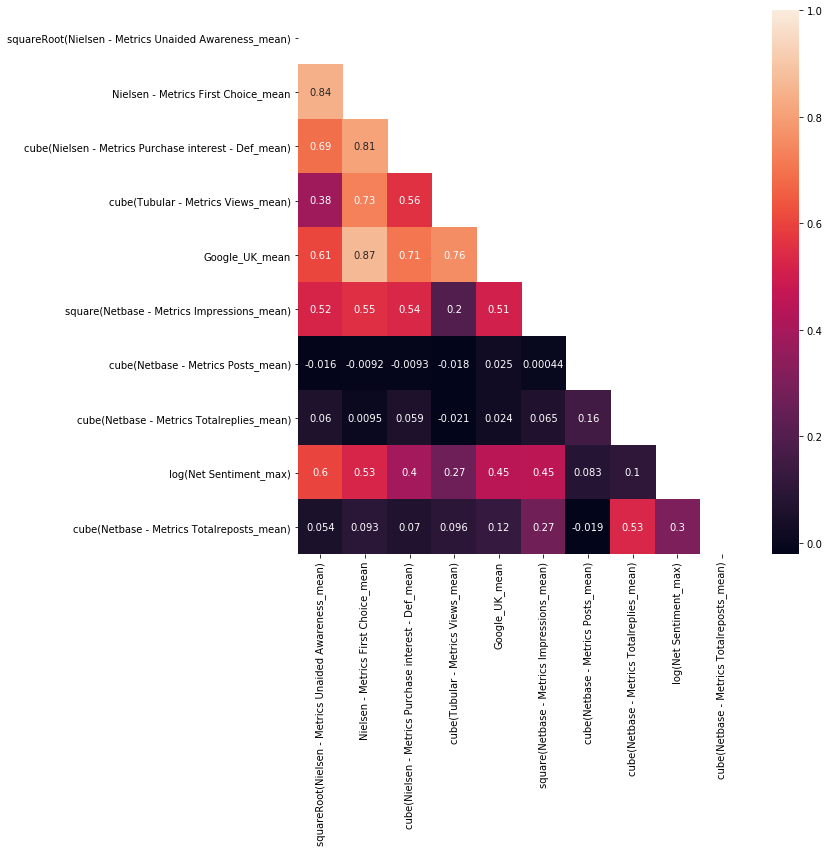

In [141]:
#Create correlation plot if necessary

#import pandas.rpy.common as com
#import seaborn as sns
#%matplotlib inline
#corr = df_vif.corr()
#corr.to_excel(path+"\\corr10features.xlsx")
#fig, ax = plt.subplots(figsize=(10, 10))
#mask = np.zeros_like(corr)
#mask[np.triu_indices_from(mask)] = 1
#sns_plot = sns.heatmap(corr,mask=mask,ax=ax,annot=True)
#fig = sns_plot.get_figure()
#fig.savefig(path+"\\corr_plot.png")
#sns_plot
#corr.to_excel(path+"correlation_plot.xlsx")

In [142]:
#Feature importance array from the RF regressor model
scores['estimator'][0].feature_importances_

array([0.10284581, 0.16256598, 0.09334227, 0.13811818, 0.11062072,
       0.10436651, 0.0437377 , 0.06600566, 0.14152337, 0.03687381])

In [143]:
#Print the error metrics & the r-squared to understand model fit

print(scores['test_wmape'].mean())
print(scores['train_wmape'].mean())
print(scores['train_Rsquare'].mean())
print(scores['train_adjRsquare'].mean())

62.353253980932315
20.001513810624694
0.9285371260598786
0.9224030859417244


In [144]:
#Export model predictions & feature importances

df_model_cv_prediction = df_transformed[['UK_Revenue']]
feature_importances = pd.DataFrame()
feature_importances['Features'] = df_vif.columns
count = 0
for model in scores['estimator']:
    pred = model.predict(df_vif)
    feat_imp = model.feature_importances_
    df_model_cv_prediction['model_'+str(count)] = pred
    feature_importances['model_'+str(count)] = feat_imp
    count = count+1
df_model_cv_prediction['mean'] = df_model_cv_prediction.mean(axis=1)
feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances.sort_values('mean',inplace=True,ascending=False)
feature_importances[['Features','mean']].to_excel(path+"\\RF_feature_importances_UK_pre_0625_fin.xlsx")
df_model_cv_prediction[['UK_Revenue','mean']].to_excel(path+"//UK_results_pre_0625_fin.xlsx")

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [145]:
#Printing out feature importances to take a look
#df_model_cv_prediction
feature_importances[['Features','mean']]

Features      mean
1                Nielsen - Metrics First Choice_mean  0.147088
3                 cube(Tubular - Metrics Views_mean)  0.133179
0  squareRoot(Nielsen - Metrics Unaided Awareness...  0.126057
5         square(Netbase - Metrics Impressions_mean)  0.117655
2  cube(Nielsen - Metrics Purchase interest - Def...  0.116475
4                                     Google_UK_mean  0.114015
8                             log(Net Sentiment_max)  0.084190
7          cube(Netbase - Metrics Totalreplies_mean)  0.079616
6                 cube(Netbase - Metrics Posts_mean)  0.042766
9          cube(Netbase - Metrics Totalreposts_mean)  0.038960

In [146]:
## Cross Validation for XGB
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer
import xgboost as xgb

mape_score = make_scorer(mean_absolute_percentage_error)
rsquare_score = make_scorer(Rsquare)
rank = np.linalg.matrix_rank(df_vif)
print(df_vif.shape)
print(rank)
adjRsquare_score = make_scorer(adjRsquare,rank = rank)
wmape_score = make_scorer(w_mape)
scoring = {'Rsquare':rsquare_score,'adjRsquare':adjRsquare_score,'mape':mape_score,'wmape':wmape_score}
gbm= xgb.XGBRegressor(n_estimators=1000,max_depth=6,max_features=int(df_vif.shape[1]/3),random_state=7)
predictions = cross_val_predict(gbm, df_vif,df_transformed['UK_Revenue'], cv=8) 
scores = cross_validate(gbm,df_vif,df_transformed['UK_Revenue'],cv=8,scoring = scoring,return_train_score=True,return_estimator=True)

(59, 10)
5
[08:55:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:55:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:55:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:55:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:55:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:55:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:55:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:55:08] WARNI

In [147]:
#Printing the scores of the XGB model
scores

{'fit_time': array([0.18749928, 0.19451451, 0.20947623, 0.20127177, 0.20644712,
        0.22140932, 0.19846869, 0.2553165 ]),
 'score_time': array([0.0069809 , 0.00797963, 0.00595212, 0.00798011, 0.00798011,
        0.00701904, 0.00699782, 0.00997376]),
 'estimator': (XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learning_rate=0.1, max_delta_step=0,
               max_depth=6, max_features=3, min_child_weight=1, missing=None,
               n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
               random_state=7, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=None, subsample=1, verbosity=1),
  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learning_rate=0.1, max_delta_step=0,
         

In [148]:
#Print out the error metrics & the r-squared for the new model.

print(scores['test_wmape'].mean())
print(scores['train_wmape'].mean())
print(scores['train_Rsquare'].mean())
print(scores['train_adjRsquare'].mean())

68.14687690430983
4.1742862979620796e-05
0.999999999999358
0.9999999999993029
